### General functions

In [2]:
## Standard imports
import numpy as np
import random
import matplotlib.pyplot as plt
import skimage.io, skimage.util, scipy.ndimage
import skimage.morphology, skimage.transform
from PIL import Image

%matplotlib inline

def show_image(img, title="untitled", cmap="gray", **kwargs):
    plt.figure()
    plt.imshow(img, cmap=cmap, interpolation="nearest", **kwargs)
    plt.axis("off")
    plt.title(title)

def reshape(img):
    return np.reshape(img, (image_width, image_height))

def reformat(img):
    formatted = (img).astype('uint16')
    return Image.fromarray(formatted)

def plot_results(input_imgs, output_imgs, labels, cmap='gist_yarg'):
    fig = plt.figure(figsize=(15, 15))
    rn = 8
    for i in range(1, 6):
        print(labels[i+rn])
        ax = fig.add_subplot(1, 5, i)
        plt.imshow(reshape(input_imgs[i+rn]), cmap=cmap)
        ax.axis('off')

    for i in range(1, 6):
        ax = fig.add_subplot(2, 5, i)
        plt.imshow(reshape(output_imgs[i+rn]), cmap=cmap)
        ax.axis('off') 

def center_crop(img, size=200):
    to_crop = (img.shape[0]-size)/2
    image_resized = skimage.util.crop(img, (to_crop, to_crop))
    return image_resized

# normalise 16-bit TIF image
def normalise(img):
    return img / 65536.0

### Read and resize dataset

#### Processing helper functions

In [7]:
def even_round(num):
    return round(num/2.)*2

# need to find a way to shuffle this pairwise!
def dataset_split(dataset, labels, test_size=0.2):
    test_size = even_round(len(dataset)*test_size)
    x_train, x_test = dataset[:-test_size], dataset[-test_size:]
    y_train, y_test = labels[:-test_size], labels[-test_size:]
    return x_train, x_test, y_train, y_test

def filenames_to_labels(filenames, folder="/Users/Leonore/Documents/Workspace/l4proj/data/processed/"):
    # 0: unstimulated
    # 1: OVA
    # 2: ConA
    # 3: unknown (human error)
    labels = []
    for file in filenames:
        file = file.split("(")[0].lstrip(folder)
        label = int("".join(_ for _ in file if _ in "123456789"))
        if label in [1, 2, 3, 4, 5, 6, 7, 8, 12, 24]:
            label = 0
        elif label in [9, 10, 11, 13, 14, 15, 23]:
            label = 1
        elif label in [16, 17, 18, 19, 20, 21, 22]:
            label = 2
        else:
            label = 3
        labels.append(label)
    return labels

In [89]:
# resize images
# read images into arrays
# read resized images back into folder for future use

import os
from skimage.io import imread, imsave
from skimage.transform import rescale, resize, downscale_local_mean

image_width = 200
image_height = 200

def resize_images(folder='/Users/Leonore/Documents/Workspace/l4proj/data/raw/', 
                  dst="/Users/Leonore/Documents/Workspace/l4proj/data/processed/CK21/CK21 - "):
    filenames = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    for file in filenames:
        if not os.path.exists(os.path.join(dst, file.replace(folder, ''))):
            try:
                image = skimage.io.imread(file)
                image_resized = center_crop(image, 200)
                img = reformat(image_resized)
                img.save(dst + file.replace(folder, ''))
            except Exception as e:
                print(e)
                print("{} is causing issues".format(file))

def images_to_dataset(folder="/Users/Leonore/Documents/Workspace/l4proj/data/processed/CK22/", ):
    filenames = [os.path.join(folder, f)for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f[0] != '.']
    filenames = sorted(filenames)
    dataset = np.ndarray(shape=(len(filenames), image_width, image_height), dtype=np.float32)
    i = 0
    for file in filenames:
        try:
            image = skimage.io.imread(file)
            dataset[i] = normalise(image)
        except Exception as e:
            print(e)
            print("{} is causing issues".format(file))
        i += 1
    return dataset, filenames 

In [90]:
## DON'T NEED TO RUN THIS ALL THE TIME!
resize_images(folder="/Users/Leonore/Downloads/OneDrive_3_07-11-2019/")

In [54]:
dataset, filenames = images_to_dataset()
labels = filenames_to_labels(filenames)

In [55]:
# x_train and x_test need to be kept in same order 
# as we need to do pairwise overlap calculations
x_train, x_test, y_train, y_test = dataset_split(dataset, labels, test_size=0.2)

x_train = np.reshape(x_train, (len(x_train), image_width, image_height, 1))
x_test = np.reshape(x_test, (len(x_test), image_width, image_height, 1))

### Build autoencoder model

In [39]:
# build autoencoder for dataset

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_width, image_height, 1))  # adapt this if using `channels_first` image data format

x =  Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Flatten()(x)
#encoded = x

#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x =  Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# this will help going back the original image dimensions
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), padding='same')(x)

In [40]:
model = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [41]:
encoder.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 200, 200, 1)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 200, 200, 32)      832       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 100, 100, 16)      4624      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 50, 50, 16)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 40000)             0         
Total params: 5,456
Trainable params: 5,456
Non-trainable params: 0
________________________________________________________

In [42]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [43]:
#model.fit(x_train, x_train, epochs=50, batch_size=50)

In [44]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = model.predict(x_test)

1
1
1
2
2


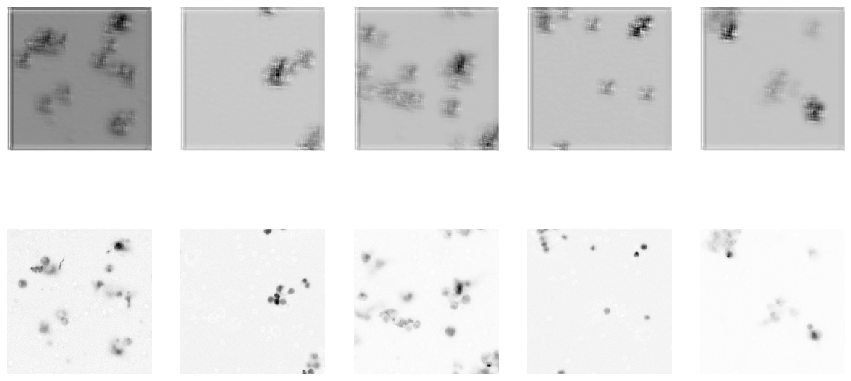

In [45]:
plot_results(x_test, decoded_imgs, y_test)

1
1
1
2
2


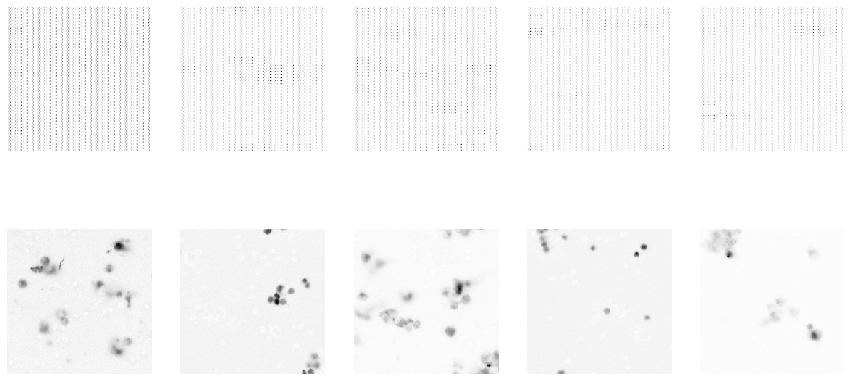

In [46]:
plot_results(x_test, encoded_imgs, y_test, cmap="gist_yarg")

### Calculate overlap between images

In [49]:
# calculate overlap between t-cell and dendritic cell
# according to stimulation
# incl. compute labels for each 

def calculate_overlap(imgs, labels):
    idx, y = 0, 0
    overlaps = np.ndarray(shape=(len(imgs)//2, image_width*image_height), dtype=np.float32)
    overlap_labels = []
    while idx < len(imgs)-1:
        tcell = imgs[idx]
        dcell = imgs[idx+1]
        #o = reshape(np.abs(dcell-tcell))
        o = np.abs(dcell-tcell)
        overlaps[y] = o
        overlap_labels.append(labels[y])
        idx += 2
        y += 1
    return overlaps, overlap_labels

x_overlap, y_overlap = calculate_overlap(encoded_imgs, y_test)
#overlap, _ = calculate_overlap(x_test, y_test)

1
1
1
2
2


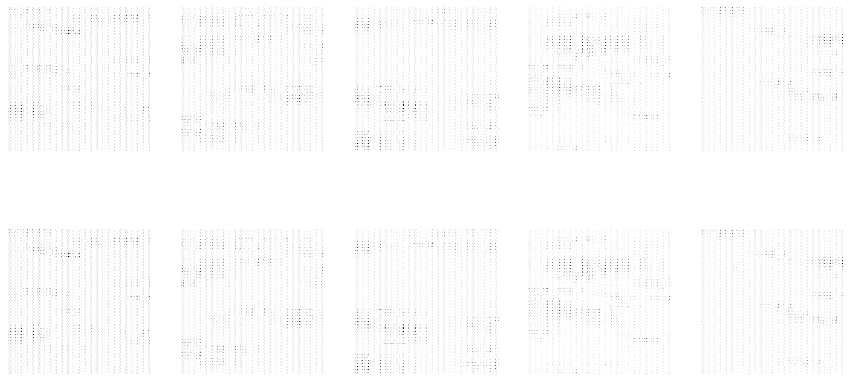

In [50]:
plot_results(x_overlap, x_overlap, y_test)

### Clustering algorithm

In [ ]:
x_overlap.shape

In [67]:
reshaped = np.reshape(x_train, (442, 40000))

In [68]:
reshaped.shape

(442, 40000)

In [69]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca_result = pca.fit_transform(reshaped)

In [73]:
y_test

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]

In [62]:
# https://www.datacamp.com/community/tutorials/introduction-t-sne
from sklearn.manifold import TSNE

tsne = TSNE()
clusters = tsne.fit_transform(pca_result)

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# choose a colour palette with seaborn
num_classes = len(np.unique(y_train))
palette = np.array(sns.color_palette("hls", num_classes))

plt.scatter(clusters[:,0], clusters[:,1], c=palette[y_train])

IndexError: index 3 is out of bounds for axis 0 with size 1

### View filters; code snippets

In [70]:
num_classes

1

In [ ]:
d1 = np.reshape(decoded_imgs[0], (image_width, image_height))
before = np.reshape(sample, (image_width, image_height))filters, biases = model.layers[1].get_weights()

In [ ]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

In [ ]:
n_filters, ix = 6, 1
for i in range(n_filters):
    f = filters[:,:,:,i]
    #plt.figure()
    #plt.imshow(f[:,:,0], cmap='gray')
    ix+=1

In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i, layer.name, layer.output.shape)

In [ ]:
# redefine model to output right after the first hidden layer
feature_model = Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
sample = np.expand_dims(x_train[44], axis=0)

In [ ]:
feature_maps = feature_model.predict(sample)

In [ ]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        plt.figure()
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1

In [ ]:
# plot the feature maps for each layer 
encoding_idx = [1, 3, 5]
outputs = [model.layers[i].output for i in encoding_idx]
feature_model = Model(inputs=model.inputs, output=outputs)
feature_maps = feature_model.predict(sample)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            plt.figure()
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
        ix += 1
    plt.show()

In [ ]:
# plot the decompressed images from each layer
decoding_idx = [7, 9, 11]
outputs = [model.layers[i].output for i in decoding_idx]
decode_model = Model(inputs=model.inputs, outputs=outputs)
output_maps = decode_model.predict(sample)
square = 8
for out in output_maps:
    ix = 1
    for _ in range(square):
        plt.figure()
        plt.imshow(out[0, :, :, ix-1], cmap='gray')
        ix+=1